# 1 Installation

In [1]:
import os
import sys
print(f"Python executable: {sys.executable}")

Python executable: /Users/martincastro/Downloads/img/venv/bin/python


In [2]:
import pandas as pd
print("Pandas version:", pd.__version__)

Pandas version: 2.0.3


In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

In [5]:
import torchvision.transforms as transforms

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import ViTForImageClassification

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import random
from datetime import datetime, timedelta
import time

In [11]:
from typing import List, Tuple

In [12]:
from apparel import ApparelDataset, ApparelStackedDataset, ApparelProfiler

# 2 Settings

In [13]:
LABELS = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

In [14]:
WEIGHTS = {
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 2,  # Coas are also hard to classify.
    5: 1,
    6: 2,  # The largest amount of errors in the confusion matrix lie here.
    7: 1,
    8: 1,
    9: 1
}

In [15]:
MODEL_PATH = "models/v4.h5"

In [16]:
PREDICTIONS_PATH = "predictions/v4.csv"

In [17]:
BATCH_SIZE = 16  # Samples per batch to load during training.

In [18]:
IMAGE_SIZE = 224  # Balance between image detail and computational cost.

In [19]:
SAMPLE_COLUMNS = 5
SAMPLE_ROWS = 4

In [20]:
RANDOM_STATE = 53  # Seed for randomized functions.

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [21]:
VALIDATION_SPLIT_RATIO = 0.2  # Ratio of validation datapoints.
TEST_SPLIT_RATIO = 0.5  # Ratio of test datapoints.

In [22]:
EPOCHS = 20  # Iterations during the training process.

In [23]:
PROCESSOR = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Processor:', PROCESSOR)

Processor: cpu


In [24]:
EARLY_STOPPING_PATIENCE = 3  # Number of epochs to wait for improvement before stopping

In [25]:
DROPOUT_RATE = 0.1  # Probability of dropping a weight during the training process.

In [26]:
LOADER_WORKERS = 4  # Amount of workers to use to load images.

In [27]:
AUGMENTED_RECORDS = 0.3  # Amount of records to include in data augmentation.

In [28]:
PRETRAINED_TRANSFORMER_NAME = 'google/vit-base-patch16-224'  # Too heavy but more powerful.
PRETRAINED_TRANSFORMER_NAME = 'facebook/deit-tiny-patch16-224'

In [29]:
STOP_AT_BATCH = None  # This is for debugging purposes. Should be set to None.

# 3 Data Loading

In this section, we define a custom dataset class `ApparelDataset` that extends the `Dataset` class from PyTorch. This custom dataset is designed to load images and their corresponding labels from a CSV file and a specified directory.

In [30]:
preprocessing = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=preprocessing)
print("Training dataset:", train_dataset, len(train_dataset), "records.")

Training dataset: <apparel.ApparelDataset object at 0x16330bf40> 60000 records.


# 4 Initial Exploratory Analysis

Performing an initial exploratory analysis of our dataset to understand its content. Additionally, plotting the distribution of labels to ensure the dataset is balanced.

In [31]:
print(train_dataset.df.dtypes)

id       int64
label    int64
dtype: object


In [32]:
def sample_dataset(dataset: Dataset) -> None:
    random_indices = random.sample(range(len(dataset)), SAMPLE_ROWS * SAMPLE_COLUMNS)
    random_images = [dataset[i][0] for i in random_indices]
    random_labels = [dataset[i][1] for i in random_indices]
    sample_images(random_images, random_labels)

In [33]:
def sample_images(images: List[np.array], labels: List[int]) -> None:
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(SAMPLE_ROWS, SAMPLE_COLUMNS, i + 1)  # Show 2 rows of 5 images.
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.imshow(img)
        plt.title(LABELS[labels[i].item()])  # The title of each image is the label.
        plt.axis("off")  # Hide the X and Y grid.
    plt.show()

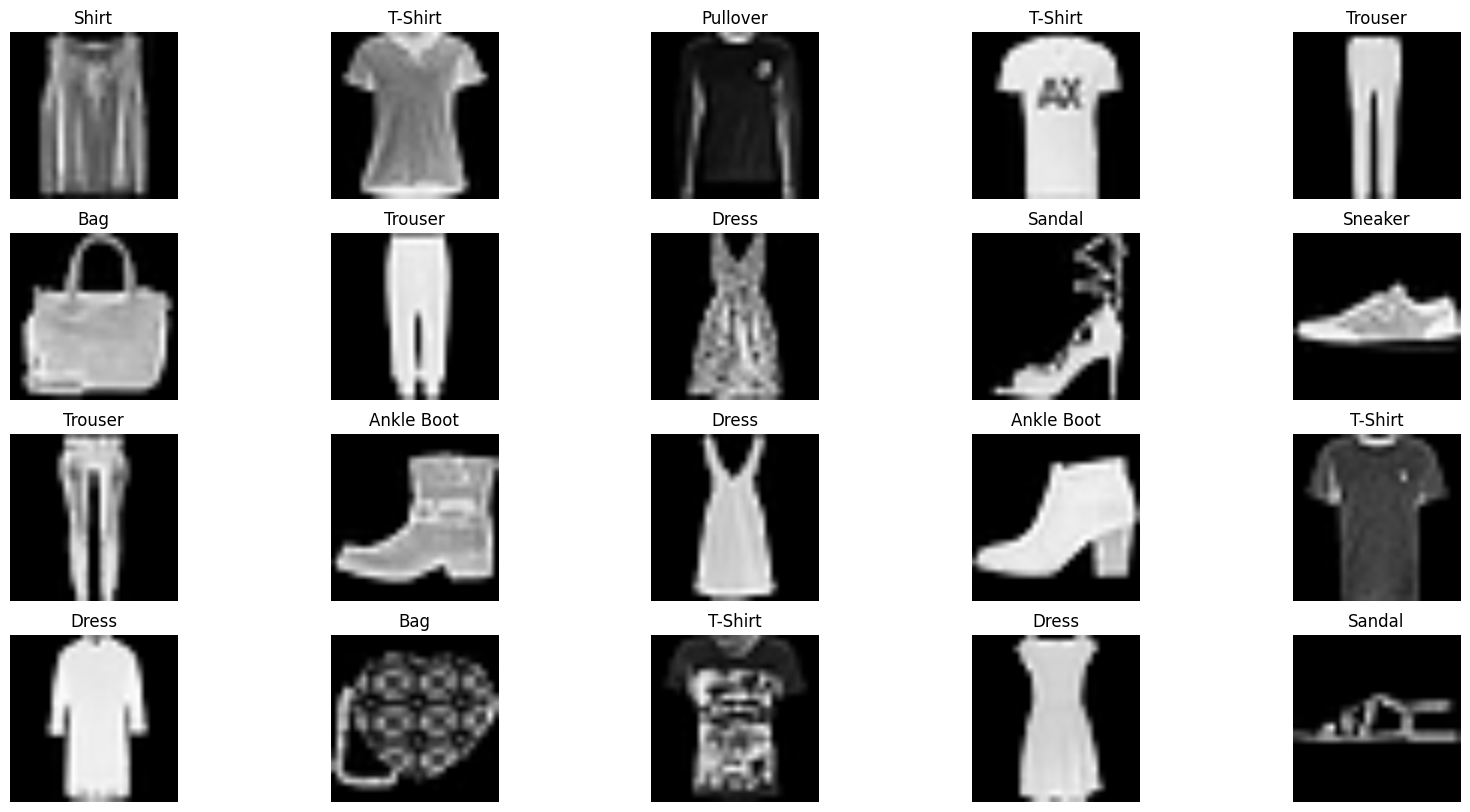

In [34]:
sample_dataset(train_dataset)

In [35]:
def plot_labels(dataset: Dataset) -> None:
    df = dataset.df
    df['label_names'] = df['label'].map(LABELS)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['label_names'], bins=len(df['label'].unique()), kde=False)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

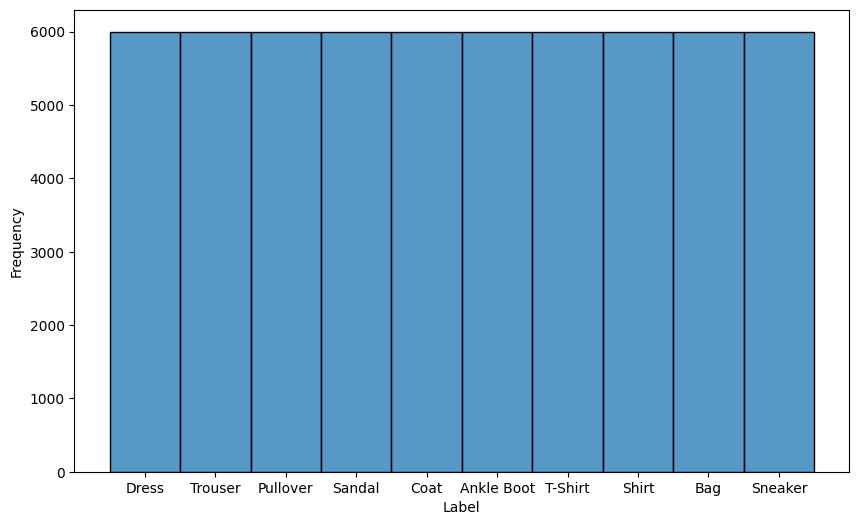

In [36]:
plot_labels(train_dataset)

# 5 Data Cleaning

Checking for null and duplicated values in the dataset. Fortunately, this dataset is already clean and balanced.

In [37]:
print("Null ids:", train_dataset.df.id.isnull().sum())

Null ids: 0


In [38]:
print("Null labels:", train_dataset.df.label.isnull().sum())

Null labels: 0


In [39]:
print("Duplicated rows:", train_dataset.df.duplicated().sum())

Duplicated rows: 0


# 6 Data Augmentation

Increasing the diversity of the training dataset to improve the robustness of our machine learning model. The augmented images are then combined with the original training dataset. This combined dataset is used to train the model.

In [40]:
augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.1),  # Horizontally flip the input with a given probability.
    transforms.RandomRotation(degrees=90),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    # transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),  # Crop a random portion of the input and resize it to a given size.
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=augmentation, sample=AUGMENTED_RECORDS)
print("Augmentation dataset:", augmented_dataset, len(augmented_dataset), "records")

Augmentation dataset: <apparel.ApparelDataset object at 0x163905ee0> 18000 records


In [41]:
augmented_train_dataset = ApparelStackedDataset(train_dataset, augmented_dataset)
print("Augmented training dataset dataset:", augmented_train_dataset, len(augmented_train_dataset), "records")

assert len(augmented_train_dataset) == len(train_dataset) + len(augmented_dataset)
assert augmented_train_dataset[0][0].equal(train_dataset[0][0])
assert augmented_train_dataset[0][1] == train_dataset[0][1]
# assert augmented_train_dataset[len(train_dataset)][0].equal(augmented_dataset[0][0])  # Reading the image generates a random variant.
assert augmented_train_dataset[len(train_dataset)][1] == augmented_dataset[0][1]

Augmented training dataset dataset: <apparel.ApparelStackedDataset object at 0x163af66d0> 78000 records


# 7 Post-Cleaning Exploratory Analysis

Repeating the exploratory analysis to verify the effectiveness of the data cleaning and augmentation steps. This ensures the data augmentation step has not created weird things.

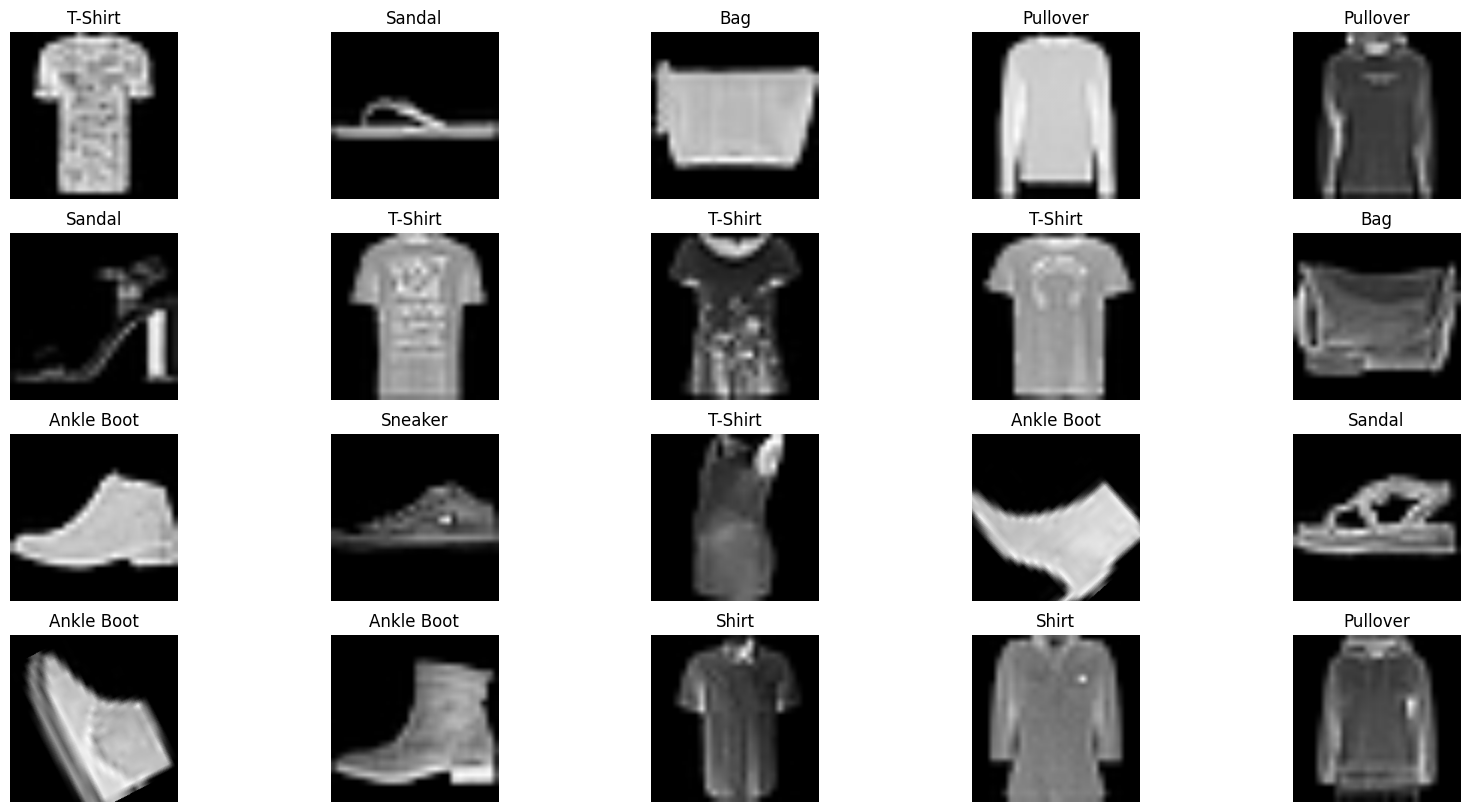

In [42]:
sample_dataset(augmented_train_dataset)

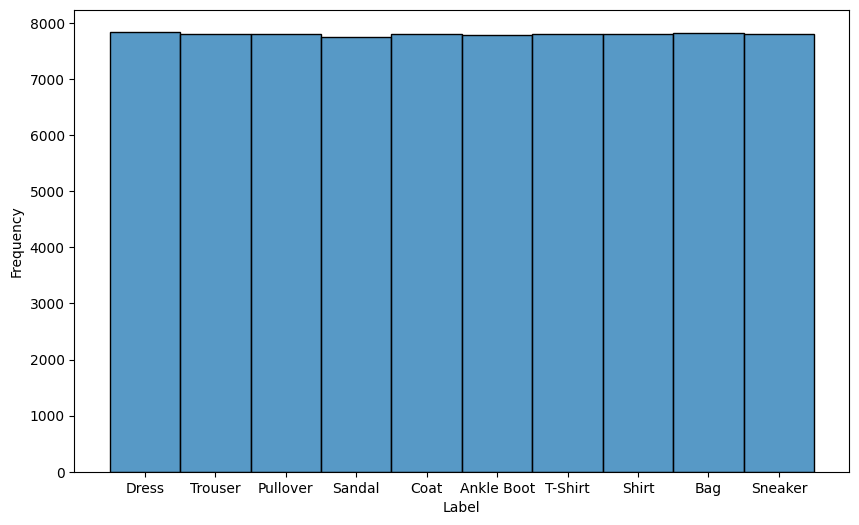

In [43]:
plot_labels(augmented_train_dataset)

# 8 Training and Validation Splitting

Splitting the augmented training dataset into training and validation sets using stratified sampling to maintain the same class distribution across both sets.

In [44]:
df = augmented_train_dataset.df
train_indices, val_test_indices = train_test_split(
    list(range(len(augmented_train_dataset))), 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=df.label, 
    random_state=RANDOM_STATE
)
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=TEST_SPLIT_RATIO, 
    stratify=[df.label[i] for i in val_test_indices], 
    random_state=RANDOM_STATE
)
assert len(augmented_train_dataset) == len(train_indices) + len(test_indices) + len(val_indices)


print("Training indices:", train_indices[:10], "...")
print("Test indices:", test_indices[:10], "...")
print("Validation indices:", val_indices[:10], "...")

Training indices: [74961, 30969, 20843, 7089, 10336, 39059, 20479, 22099, 19709, 10898] ...
Test indices: [60665, 47015, 24298, 45379, 71713, 74622, 58047, 737, 66373, 9623] ...
Validation indices: [48109, 10325, 74820, 20792, 11602, 76860, 28864, 70740, 69473, 46673] ...


In [45]:
train_subset = Subset(augmented_train_dataset, train_indices)
test_subset = Subset(augmented_train_dataset, test_indices)
val_subset = Subset(augmented_train_dataset, val_indices)
assert len(train_subset) + len(test_subset) + len(val_subset) == len(augmented_train_dataset)
print("Training dataset:", train_subset, len(train_subset), "records")
print("Test dataset:", test_subset, len(test_subset), "records")
print("Validation dataset:", val_subset, len(val_subset), "records")

Training dataset: <torch.utils.data.dataset.Subset object at 0x163b947f0> 62400 records
Test dataset: <torch.utils.data.dataset.Subset object at 0x163b94ca0> 7800 records
Validation dataset: <torch.utils.data.dataset.Subset object at 0x164250bb0> 7800 records


In [46]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)

# 8 Model Preparation

Loading a pre-trained Vision Transformer model specifically designed for image classification with 10 labels using `ViTForImageClassification` from the Hugging Face, which is configured for a GPU (if available). Additionally, an Adam optimizer is set up with a learning rate of `1e-4` to adjust the model's parameters during training, and a cross-entropy loss function is defined to measure the performance of the model by comparing its predictions against the true labels.

In [47]:
class ApparelsModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super(ApparelsModel, self).__init__()

        self.base_model = base_model
        # Freeze the base model
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.new_layers = nn.Sequential(
            nn.Linear(base_model.config.hidden_size, 2048),
            nn.BatchNorm1d(2048),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(512, num_labels)
        )
        
    def forward(self, x):
        x = self.base_model.vit(x)  # Pass through the base ViT model
        x = x.last_hidden_state[:, 0]  # Get the output of the [CLS] token
        x = self.new_layers(x)  # Pass through the new layers
        return x

    def forward(self, x):
        # profiler = ApparelProfiler("Forward")
        # profiler.measure("BaseModel")
        x = self.base_model.vit(x)
        # profiler.measure("NewLayers")
        x = x.last_hidden_state[:, 0]
        x = self.new_layers(x)
        # profiler.stop()
        return x

In [48]:
base_model = ViTForImageClassification.from_pretrained(
    PRETRAINED_TRANSFORMER_NAME,
    ignore_mismatched_sizes=True,
    num_labels=len(LABELS)
)

model = ApparelsModel(base_model, num_labels=len(LABELS))
model = model.to(PROCESSOR)
print("Model:", model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: ApparelsModel(
  (base_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=True)
                (value): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
        

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
class_weights = torch.tensor([
    WEIGHTS.get(i, 1)
    for i in range(len(LABELS))
], dtype=torch.float).to(PROCESSOR)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Optimizer:", optimizer)
print("Loss function:", loss_function)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 10 Model Training

Training the model, including forward and backward passes, validation, and early stopping.

In [50]:
def get_eta(start_time: float, current_batch: int, total_batches: int) -> datetime:
    elapsed_time = time.time() - start_time
    average_time_per_batch = elapsed_time / max(1, current_batch)
    pending_batches = total_batches - current_batch
    return datetime.now() + timedelta(seconds=average_time_per_batch * pending_batches)

In [51]:
def train_epoch(model: ApparelsModel) -> ApparelsModel:
    model.train()
    start_time = time.time()
    for batch_number, batch in enumerate(train_loader):
        print(datetime.now(), "Train - Batch:", batch_number, "of", len(train_loader), "ETA:", get_eta(start_time, batch_number, len(train_loader)))
        inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_number == STOP_AT_BATCH: break
    return model

In [52]:
def evaluate_model(model: ApparelsModel, loader: DataLoader) -> Tuple[float, float, np.array]:
    loss = 0
    y_hat = []
    y_true = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, batch in enumerate(loader):
            print(datetime.now(), "Val - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
            outputs = model(inputs)
            batch_loss = loss_function(outputs, labels)
            loss += batch_loss.item()
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    loss /= len(loader)
    accuracy = accuracy_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)
    return loss, accuracy, conf_matrix

In [53]:
def train(model: ApparelsModel, epochs: int, best_loss: float = float('inf')) -> Tuple[ApparelsModel, List[float]]:
    early_stop_counter = 0
    accuracies: List[float] = []
    for epoch in range(epochs):
        print(datetime.now(), "Epoch:", epoch)
        model = train_epoch(model)
        val_loss, val_accuracy, _ = evaluate_model(model, val_loader)
        accuracies.append(val_accuracy)
        print(datetime.now(), "Epoch:", epoch, "of", epochs, "Loss:", val_loss, "Accuracy:", val_accuracy),
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)
            continue
        early_stop_counter += 1
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping!")
            model.load_state_dict(torch.load(MODEL_PATH))
            break
    print(datetime.now(), "Training complete!")
    return model, accuracies

In [54]:
model, accuracies = train(model=model, epochs=EPOCHS)
print(f"Model Accuracy: {accuracies[-1]}")

2024-06-23 22:59:27.031906 Epoch: 0
2024-06-23 22:59:37.848736 Train - Batch: 0 of 3900 ETA: 2024-06-24 10:42:39.874048
2024-06-23 22:59:38.361153 Train - Batch: 1 of 3900 ETA: 2024-06-24 11:15:47.203939
2024-06-23 22:59:38.841970 Train - Batch: 2 of 3900 ETA: 2024-06-24 05:23:14.713597
2024-06-23 22:59:39.314092 Train - Batch: 3 of 3900 ETA: 2024-06-24 03:25:32.578580
2024-06-23 22:59:39.825755 Train - Batch: 4 of 3900 ETA: 2024-06-24 02:27:20.063785
2024-06-23 22:59:40.315653 Train - Batch: 5 of 3900 ETA: 2024-06-24 01:52:07.578027
2024-06-23 22:59:40.791054 Train - Batch: 6 of 3900 ETA: 2024-06-24 01:28:29.831730
2024-06-23 22:59:41.274316 Train - Batch: 7 of 3900 ETA: 2024-06-24 01:11:41.533855
2024-06-23 22:59:41.766494 Train - Batch: 8 of 3900 ETA: 2024-06-24 00:59:09.657996
2024-06-23 22:59:42.246240 Train - Batch: 9 of 3900 ETA: 2024-06-24 00:49:19.478522
2024-06-23 22:59:42.743830 Train - Batch: 10 of 3900 ETA: 2024-06-24 00:41:34.294832
2024-06-23 22:59:43.419024 Train - Batc

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 23:30:32.146899 Val - Batch: 0 of 488 ETA: 2024-06-24 00:50:37.186820
2024-06-23 23:30:32.630579 Val - Batch: 1 of 488 ETA: 2024-06-24 00:54:23.346019
2024-06-23 23:30:33.065384 Val - Batch: 2 of 488 ETA: 2024-06-24 00:14:08.915238
2024-06-23 23:30:33.501146 Val - Batch: 3 of 488 ETA: 2024-06-24 00:00:44.260962
2024-06-23 23:30:33.925772 Val - Batch: 4 of 488 ETA: 2024-06-23 23:54:00.575225
2024-06-23 23:30:34.351161 Val - Batch: 5 of 488 ETA: 2024-06-23 23:49:58.438269
2024-06-23 23:30:34.802577 Val - Batch: 6 of 488 ETA: 2024-06-23 23:47:19.130491
2024-06-23 23:30:35.231345 Val - Batch: 7 of 488 ETA: 2024-06-23 23:45:23.760259
2024-06-23 23:30:35.670114 Val - Batch: 8 of 488 ETA: 2024-06-23 23:43:57.842774
2024-06-23 23:30:36.109704 Val - Batch: 9 of 488 ETA: 2024-06-23 23:42:51.062522
2024-06-23 23:30:36.561645 Val - Batch: 10 of 488 ETA: 2024-06-23 23:41:58.241049
2024-06-23 23:30:37.000185 Val - Batch: 11 of 488 ETA: 2024-06-23 23:41:14.429005
2024-06-23 23:30:37.431006

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 23:34:25.506560 Epoch: 0 of 20 Loss: 0.48030956116978263 Accuracy: 0.8398717948717949
2024-06-23 23:34:25.570551 Epoch: 1
2024-06-23 23:34:35.777141 Train - Batch: 0 of 3900 ETA: 2024-06-24 10:37:56.654950
2024-06-23 23:34:36.291541 Train - Batch: 1 of 3900 ETA: 2024-06-24 11:11:12.327876
2024-06-23 23:34:36.789344 Train - Batch: 2 of 3900 ETA: 2024-06-24 05:38:59.669394
2024-06-23 23:34:37.313748 Train - Batch: 3 of 3900 ETA: 2024-06-24 03:48:50.032850
2024-06-23 23:34:37.797007 Train - Batch: 4 of 3900 ETA: 2024-06-24 02:53:05.092307
2024-06-23 23:34:38.263523 Train - Batch: 5 of 3900 ETA: 2024-06-24 02:19:25.070714
2024-06-23 23:34:38.731528 Train - Batch: 6 of 3900 ETA: 2024-06-24 01:56:59.356681
2024-06-23 23:34:39.201449 Train - Batch: 7 of 3900 ETA: 2024-06-24 01:40:59.201676
2024-06-23 23:34:39.672579 Train - Batch: 8 of 3900 ETA: 2024-06-24 01:28:59.673427
2024-06-23 23:34:40.142615 Train - Batch: 9 of 3900 ETA: 2024-06-24 01:19:39.566646
2024-06-23 23:34:40.608794 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 00:05:05.256795 Val - Batch: 0 of 488 ETA: 2024-06-24 01:25:05.218128
2024-06-24 00:05:05.743002 Val - Batch: 1 of 488 ETA: 2024-06-24 01:28:52.612534
2024-06-24 00:05:06.164904 Val - Batch: 2 of 488 ETA: 2024-06-24 00:48:36.960850
2024-06-24 00:05:06.623636 Val - Batch: 3 of 488 ETA: 2024-06-24 00:35:17.735056
2024-06-24 00:05:07.069702 Val - Batch: 4 of 488 ETA: 2024-06-24 00:28:36.576210
2024-06-24 00:05:07.484130 Val - Batch: 5 of 488 ETA: 2024-06-24 00:24:32.793506
2024-06-24 00:05:07.916453 Val - Batch: 6 of 488 ETA: 2024-06-24 00:21:51.727028
2024-06-24 00:05:08.326311 Val - Batch: 7 of 488 ETA: 2024-06-24 00:19:55.113329
2024-06-24 00:05:08.744929 Val - Batch: 8 of 488 ETA: 2024-06-24 00:18:28.187458
2024-06-24 00:05:09.177623 Val - Batch: 9 of 488 ETA: 2024-06-24 00:17:21.341755
2024-06-24 00:05:09.602234 Val - Batch: 10 of 488 ETA: 2024-06-24 00:16:27.470646
2024-06-24 00:05:10.026791 Val - Batch: 11 of 488 ETA: 2024-06-24 00:15:43.391923
2024-06-24 00:05:10.443437

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 00:08:52.565627 Epoch: 1 of 20 Loss: 0.4334074175443317 Accuracy: 0.8588461538461538
2024-06-24 00:08:52.627535 Epoch: 2
2024-06-24 00:09:01.802827 Train - Batch: 0 of 3900 ETA: 2024-06-24 10:05:20.738672
2024-06-24 00:09:02.286911 Train - Batch: 1 of 3900 ETA: 2024-06-24 10:36:39.265810
2024-06-24 00:09:02.738332 Train - Batch: 2 of 3900 ETA: 2024-06-24 05:37:26.224351
2024-06-24 00:09:03.210278 Train - Batch: 3 of 3900 ETA: 2024-06-24 03:58:08.556572
2024-06-24 00:09:03.685152 Train - Batch: 4 of 3900 ETA: 2024-06-24 03:08:32.576105
2024-06-24 00:09:04.140912 Train - Batch: 5 of 3900 ETA: 2024-06-24 02:38:32.079449
2024-06-24 00:09:04.607985 Train - Batch: 6 of 3900 ETA: 2024-06-24 02:18:39.101771
2024-06-24 00:09:05.070300 Train - Batch: 7 of 3900 ETA: 2024-06-24 02:04:24.323507
2024-06-24 00:09:05.558720 Train - Batch: 8 of 3900 ETA: 2024-06-24 01:53:55.975142
2024-06-24 00:09:06.013194 Train - Batch: 9 of 3900 ETA: 2024-06-24 01:45:32.534612
2024-06-24 00:09:06.483936 T

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 00:39:29.641393 Val - Batch: 0 of 488 ETA: 2024-06-24 01:56:01.469624
2024-06-24 00:39:30.099654 Val - Batch: 1 of 488 ETA: 2024-06-24 01:59:35.661261
2024-06-24 00:39:30.523669 Val - Batch: 2 of 488 ETA: 2024-06-24 01:21:11.406354
2024-06-24 00:39:30.955001 Val - Batch: 3 of 488 ETA: 2024-06-24 01:08:24.511358
2024-06-24 00:39:31.393310 Val - Batch: 4 of 488 ETA: 2024-06-24 01:02:01.915236
2024-06-24 00:39:31.819598 Val - Batch: 5 of 488 ETA: 2024-06-24 00:58:11.184378
2024-06-24 00:39:32.232176 Val - Batch: 6 of 488 ETA: 2024-06-24 00:55:36.248666
2024-06-24 00:39:32.647381 Val - Batch: 7 of 488 ETA: 2024-06-24 00:53:45.763432
2024-06-24 00:39:33.078783 Val - Batch: 8 of 488 ETA: 2024-06-24 00:52:23.887463
2024-06-24 00:39:33.496186 Val - Batch: 9 of 488 ETA: 2024-06-24 00:51:19.447202
2024-06-24 00:39:33.925504 Val - Batch: 10 of 488 ETA: 2024-06-24 00:50:28.476444
2024-06-24 00:39:34.362326 Val - Batch: 11 of 488 ETA: 2024-06-24 00:49:47.106011
2024-06-24 00:39:34.788419

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 00:43:17.592527 Epoch: 2 of 20 Loss: 0.41842786884546035 Accuracy: 0.8665384615384616
2024-06-24 00:43:17.653389 Epoch: 3
2024-06-24 00:43:26.909486 Train - Batch: 0 of 3900 ETA: 2024-06-24 10:45:01.355210
2024-06-24 00:43:27.405420 Train - Batch: 1 of 3900 ETA: 2024-06-24 11:17:05.790031
2024-06-24 00:43:27.872980 Train - Batch: 2 of 3900 ETA: 2024-06-24 06:15:23.468156
2024-06-24 00:43:28.330194 Train - Batch: 3 of 3900 ETA: 2024-06-24 04:34:35.908359
2024-06-24 00:43:28.789715 Train - Batch: 4 of 3900 ETA: 2024-06-24 03:44:14.377957
2024-06-24 00:43:29.246902 Train - Batch: 5 of 3900 ETA: 2024-06-24 03:13:59.640034
2024-06-24 00:43:29.718389 Train - Batch: 6 of 3900 ETA: 2024-06-24 02:53:59.108427
2024-06-24 00:43:30.188307 Train - Batch: 7 of 3900 ETA: 2024-06-24 02:39:40.712739
2024-06-24 00:43:30.645891 Train - Batch: 8 of 3900 ETA: 2024-06-24 02:28:50.902744
2024-06-24 00:43:31.104337 Train - Batch: 9 of 3900 ETA: 2024-06-24 02:20:25.867938
2024-06-24 00:43:31.569934 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 01:14:01.430390 Val - Batch: 0 of 488 ETA: 2024-06-24 02:30:04.923886
2024-06-24 01:14:01.897767 Val - Batch: 1 of 488 ETA: 2024-06-24 02:33:43.611110
2024-06-24 01:14:02.333174 Val - Batch: 2 of 488 ETA: 2024-06-24 01:55:34.083625
2024-06-24 01:14:02.751719 Val - Batch: 3 of 488 ETA: 2024-06-24 01:42:48.165430
2024-06-24 01:14:03.185762 Val - Batch: 4 of 488 ETA: 2024-06-24 01:36:27.097194
2024-06-24 01:14:03.609374 Val - Batch: 5 of 488 ETA: 2024-06-24 01:32:37.438113
2024-06-24 01:14:04.049871 Val - Batch: 6 of 488 ETA: 2024-06-24 01:30:05.705435
2024-06-24 01:14:04.481890 Val - Batch: 7 of 488 ETA: 2024-06-24 01:28:16.733783
2024-06-24 01:14:04.906280 Val - Batch: 8 of 488 ETA: 2024-06-24 01:26:54.539812
2024-06-24 01:14:05.326253 Val - Batch: 9 of 488 ETA: 2024-06-24 01:25:50.371529
2024-06-24 01:14:05.768211 Val - Batch: 10 of 488 ETA: 2024-06-24 01:25:00.109796
2024-06-24 01:14:06.203953 Val - Batch: 11 of 488 ETA: 2024-06-24 01:24:18.710869
2024-06-24 01:14:06.623638

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 01:17:50.049597 Epoch: 3 of 20 Loss: 0.40612012178056917 Accuracy: 0.8671794871794872
2024-06-24 01:17:50.112206 Epoch: 4
2024-06-24 01:17:59.741947 Train - Batch: 0 of 3900 ETA: 2024-06-24 11:43:51.407172
2024-06-24 01:18:00.253475 Train - Batch: 1 of 3900 ETA: 2024-06-24 12:16:56.211511
2024-06-24 01:18:00.720781 Train - Batch: 2 of 3900 ETA: 2024-06-24 07:02:34.410854
2024-06-24 01:18:01.190910 Train - Batch: 3 of 3900 ETA: 2024-06-24 05:17:50.815255
2024-06-24 01:18:01.659379 Train - Batch: 4 of 3900 ETA: 2024-06-24 04:25:27.395132
2024-06-24 01:18:02.128893 Train - Batch: 5 of 3900 ETA: 2024-06-24 03:54:02.160566
2024-06-24 01:18:02.591891 Train - Batch: 6 of 3900 ETA: 2024-06-24 03:33:01.101361
2024-06-24 01:18:03.074474 Train - Batch: 7 of 3900 ETA: 2024-06-24 03:18:11.256502
2024-06-24 01:18:03.524111 Train - Batch: 8 of 3900 ETA: 2024-06-24 03:06:47.811745
2024-06-24 01:18:03.988783 Train - Batch: 9 of 3900 ETA: 2024-06-24 02:58:02.758214
2024-06-24 01:18:04.450568 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 01:48:44.460097 Val - Batch: 0 of 488 ETA: 2024-06-24 03:15:38.556719
2024-06-24 01:48:44.927960 Val - Batch: 1 of 488 ETA: 2024-06-24 03:19:16.135058
2024-06-24 01:48:45.354808 Val - Batch: 2 of 488 ETA: 2024-06-24 02:35:39.106749
2024-06-24 01:48:45.771579 Val - Batch: 3 of 488 ETA: 2024-06-24 02:21:05.124284
2024-06-24 01:48:46.190513 Val - Batch: 4 of 488 ETA: 2024-06-24 02:13:48.397190
2024-06-24 01:48:46.613369 Val - Batch: 5 of 488 ETA: 2024-06-24 02:09:26.743418
2024-06-24 01:48:47.042345 Val - Batch: 6 of 488 ETA: 2024-06-24 02:06:32.805734
2024-06-24 01:48:47.474325 Val - Batch: 7 of 488 ETA: 2024-06-24 02:04:28.773675
2024-06-24 01:48:47.897976 Val - Batch: 8 of 488 ETA: 2024-06-24 02:02:55.241568
2024-06-24 01:48:48.319230 Val - Batch: 9 of 488 ETA: 2024-06-24 02:01:42.364619
2024-06-24 01:48:48.744525 Val - Batch: 10 of 488 ETA: 2024-06-24 02:00:44.259922
2024-06-24 01:48:49.180813 Val - Batch: 11 of 488 ETA: 2024-06-24 01:59:57.207667
2024-06-24 01:48:49.614963

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 01:52:33.533108 Epoch: 4 of 20 Loss: 0.41367496444736834 Accuracy: 0.8676923076923077
2024-06-24 01:52:33.533303 Epoch: 5
2024-06-24 01:52:43.810170 Train - Batch: 0 of 3900 ETA: 2024-06-24 13:00:38.479049
2024-06-24 01:52:44.304981 Train - Batch: 1 of 3900 ETA: 2024-06-24 13:32:37.517509
2024-06-24 01:52:44.770751 Train - Batch: 2 of 3900 ETA: 2024-06-24 07:57:43.779967
2024-06-24 01:52:45.211724 Train - Batch: 3 of 3900 ETA: 2024-06-24 06:05:33.629850
2024-06-24 01:52:45.685564 Train - Batch: 4 of 3900 ETA: 2024-06-24 05:10:00.599143
2024-06-24 01:52:46.150828 Train - Batch: 5 of 3900 ETA: 2024-06-24 04:36:34.092808
2024-06-24 01:52:46.609238 Train - Batch: 6 of 3900 ETA: 2024-06-24 04:14:11.966314
2024-06-24 01:52:47.074236 Train - Batch: 7 of 3900 ETA: 2024-06-24 03:58:16.974449
2024-06-24 01:52:47.525560 Train - Batch: 8 of 3900 ETA: 2024-06-24 03:46:14.064930
2024-06-24 01:52:47.981285 Train - Batch: 9 of 3900 ETA: 2024-06-24 03:36:53.709573
2024-06-24 01:52:48.445024 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 02:23:33.184599 Val - Batch: 0 of 488 ETA: 2024-06-24 03:50:16.193215
2024-06-24 02:23:33.649967 Val - Batch: 1 of 488 ETA: 2024-06-24 03:53:52.584138
2024-06-24 02:23:34.068825 Val - Batch: 2 of 488 ETA: 2024-06-24 03:10:19.754838
2024-06-24 02:23:34.492646 Val - Batch: 3 of 488 ETA: 2024-06-24 02:55:49.619390
2024-06-24 02:23:34.925139 Val - Batch: 4 of 488 ETA: 2024-06-24 02:48:35.609270
2024-06-24 02:23:35.353248 Val - Batch: 5 of 488 ETA: 2024-06-24 02:44:14.775316
2024-06-24 02:23:35.800079 Val - Batch: 6 of 488 ETA: 2024-06-24 02:41:22.408897
2024-06-24 02:23:36.221202 Val - Batch: 7 of 488 ETA: 2024-06-24 02:39:17.497664
2024-06-24 02:23:36.641417 Val - Batch: 8 of 488 ETA: 2024-06-24 02:37:43.758988
2024-06-24 02:23:37.060725 Val - Batch: 9 of 488 ETA: 2024-06-24 02:36:30.801900
2024-06-24 02:23:37.517399 Val - Batch: 10 of 488 ETA: 2024-06-24 02:35:34.259665
2024-06-24 02:23:37.960043 Val - Batch: 11 of 488 ETA: 2024-06-24 02:34:47.375435
2024-06-24 02:23:38.399944

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 02:27:22.757274 Epoch: 5 of 20 Loss: 0.4142041985006606 Accuracy: 0.8719230769230769
2024-06-24 02:27:22.757448 Epoch: 6
2024-06-24 02:27:33.202482 Train - Batch: 0 of 3900 ETA: 2024-06-24 13:46:24.381405
2024-06-24 02:27:33.711435 Train - Batch: 1 of 3900 ETA: 2024-06-24 14:19:18.491015
2024-06-24 02:27:34.169296 Train - Batch: 2 of 3900 ETA: 2024-06-24 08:38:13.457889
2024-06-24 02:27:34.633231 Train - Batch: 3 of 3900 ETA: 2024-06-24 06:44:39.673839
2024-06-24 02:27:35.093524 Train - Batch: 4 of 3900 ETA: 2024-06-24 05:47:49.230550
2024-06-24 02:27:35.580381 Train - Batch: 5 of 3900 ETA: 2024-06-24 05:14:03.684592
2024-06-24 02:27:36.042661 Train - Batch: 6 of 3900 ETA: 2024-06-24 04:51:17.345633
2024-06-24 02:27:36.512429 Train - Batch: 7 of 3900 ETA: 2024-06-24 04:35:05.561127
2024-06-24 02:27:36.988607 Train - Batch: 8 of 3900 ETA: 2024-06-24 04:22:59.847566
2024-06-24 02:27:37.448771 Train - Batch: 9 of 3900 ETA: 2024-06-24 04:13:28.463932
2024-06-24 02:27:37.916455 T

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 02:58:20.347627 Val - Batch: 0 of 488 ETA: 2024-06-24 04:23:58.697921
2024-06-24 02:58:20.810007 Val - Batch: 1 of 488 ETA: 2024-06-24 04:27:33.755701
2024-06-24 02:58:21.249137 Val - Batch: 2 of 488 ETA: 2024-06-24 03:44:38.935053
2024-06-24 02:58:21.680275 Val - Batch: 3 of 488 ETA: 2024-06-24 03:30:19.361118
2024-06-24 02:58:22.111247 Val - Batch: 4 of 488 ETA: 2024-06-24 03:23:09.554109
2024-06-24 02:58:22.537906 Val - Batch: 5 of 488 ETA: 2024-06-24 03:18:51.248794
2024-06-24 02:58:22.973673 Val - Batch: 6 of 488 ETA: 2024-06-24 03:15:59.786253
2024-06-24 02:58:23.400680 Val - Batch: 7 of 488 ETA: 2024-06-24 03:13:56.702047
2024-06-24 02:58:23.818227 Val - Batch: 8 of 488 ETA: 2024-06-24 03:12:23.811835
2024-06-24 02:58:24.247774 Val - Batch: 9 of 488 ETA: 2024-06-24 03:11:12.214770
2024-06-24 02:58:24.667715 Val - Batch: 10 of 488 ETA: 2024-06-24 03:10:14.468293
2024-06-24 02:58:25.096658 Val - Batch: 11 of 488 ETA: 2024-06-24 03:09:27.620450
2024-06-24 02:58:25.536913

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 03:02:09.802521 Epoch: 6 of 20 Loss: 0.4232287990181234 Accuracy: 0.8697435897435898
Early stopping!
2024-06-24 03:02:09.860481 Training complete!
Model Accuracy: 0.8697435897435898


# 11 Model Evaluation

Eavluating the model's performance on the test set by calculating the test loss, accuracy, and confusion matrix.

In [55]:
test_loss, test_accuracy, conf_matrix = evaluate_model(model, test_loader)

2024-06-24 03:02:19.171084 Val - Batch: 0 of 488 ETA: 2024-06-24 04:17:58.877074
2024-06-24 03:02:19.646271 Val - Batch: 1 of 488 ETA: 2024-06-24 04:21:41.417746
2024-06-24 03:02:20.095346 Val - Batch: 2 of 488 ETA: 2024-06-24 03:43:45.217200
2024-06-24 03:02:20.518404 Val - Batch: 3 of 488 ETA: 2024-06-24 03:31:02.251748
2024-06-24 03:02:20.935667 Val - Batch: 4 of 488 ETA: 2024-06-24 03:24:40.061915
2024-06-24 03:02:21.352635 Val - Batch: 5 of 488 ETA: 2024-06-24 03:20:50.719418
2024-06-24 03:02:21.778734 Val - Batch: 6 of 488 ETA: 2024-06-24 03:18:18.567148
2024-06-24 03:02:22.199487 Val - Batch: 7 of 488 ETA: 2024-06-24 03:16:29.513993
2024-06-24 03:02:22.620126 Val - Batch: 8 of 488 ETA: 2024-06-24 03:15:07.717276
2024-06-24 03:02:23.042675 Val - Batch: 9 of 488 ETA: 2024-06-24 03:14:04.201183
2024-06-24 03:02:23.465154 Val - Batch: 10 of 488 ETA: 2024-06-24 03:13:13.384888
2024-06-24 03:02:23.896430 Val - Batch: 11 of 488 ETA: 2024-06-24 03:12:32.198152
2024-06-24 03:02:24.327346

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

In [56]:
print("Test Loss:", test_loss)
print("Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

Test Loss: 0.3977475563965005
Accuracy: 0.8732051282051282
Confusion Matrix:
 [[646   1   9  32   7   1  74   0   8   2]
 [  0 756   2  16   5   0   1   1   0   0]
 [ 16   0 603  10  74   0  66   1  10   0]
 [ 20  20   2 680  25   0  34   1   2   1]
 [  3   2  34  26 671   0  36   0   8   0]
 [  1   0   0   1   0 724   1  36   3   9]
 [109   1  36  40  79   0 508   1   5   0]
 [  0   2   0   3   0  14   0 750   0  11]
 [  4   4   3   5   9   2   8   0 746   1]
 [  0   0   0   0   0   9   0  42   0 727]]


# 12 Performance Tuning

Visualizing the validation loss and test loss over epochs and the confusion matrix. This step help update the settings of the model to improve the results. Additionally, there are multiple versions of this model, so at the end of the day, we only keep the best one.

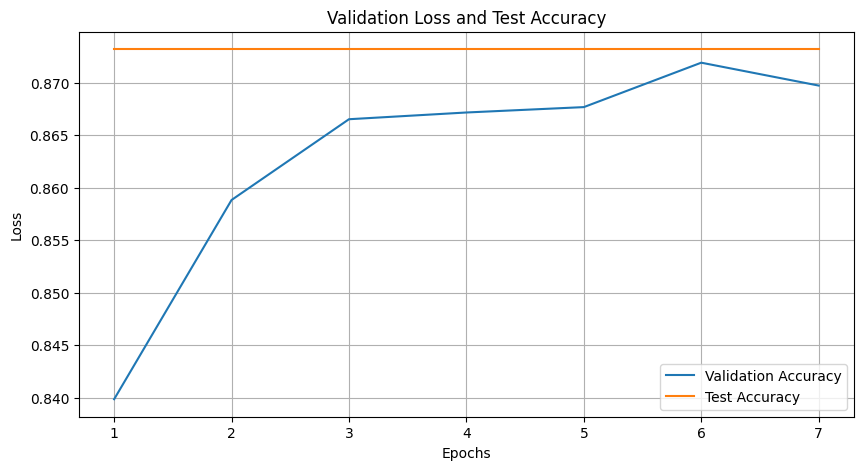

In [57]:
assert len(accuracies) > 0
assert test_accuracy > 0
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Validation Accuracy')
plt.plot(range(1, len(accuracies) + 1), [test_accuracy for _ in range(len(accuracies))], label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

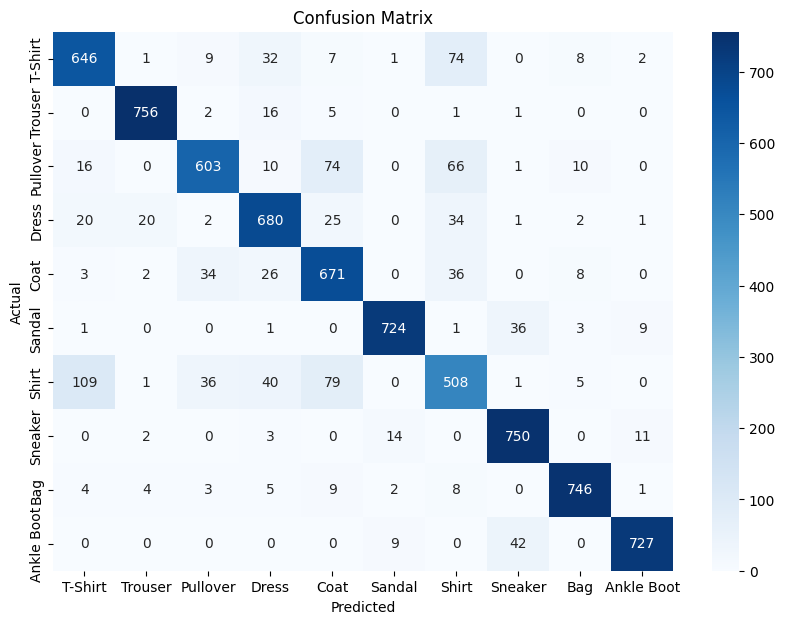

In [58]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.values(), yticklabels=LABELS.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13 Prediction

Generating the CSV to submit to DataHack.

In [59]:
submission_dataset = ApparelDataset.load(csv_path='data/test.csv', images_path='data/test', preprocessing=preprocessing)
submission_loader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
print("Submission dataset:", submission_dataset, len(submission_dataset), "records.")

Submission dataset: <apparel.ApparelDataset object at 0x16467c880> 10000 records.


In [60]:
def predict(model: ApparelsModel, loader: DataLoader) -> np.array:
    y_hat = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, inputs in enumerate(loader):
            print(datetime.now(), "Prediction - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs = inputs.to(PROCESSOR)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    return y_hat

In [61]:
predictions = predict(model, submission_loader)

if isinstance(STOP_AT_BATCH, int) and STOP_AT_BATCH >= 0:
    submission_dataset.df = submission_dataset.df.iloc[:len(predictions)].copy()
assert len(predictions) == len(submission_dataset)

submission_dataset.df['label'] = predict(model, submission_loader)
submission_dataset.df.to_csv(PREDICTIONS_PATH, index=False)

2024-06-24 03:06:12.639854 Prediction - Batch: 0 of 625 ETA: 2024-06-24 03:48:30.398922
2024-06-24 03:06:13.114301 Prediction - Batch: 1 of 625 ETA: 2024-06-24 03:53:22.812159
2024-06-24 03:06:13.547492 Prediction - Batch: 2 of 625 ETA: 2024-06-24 03:32:01.066726
2024-06-24 03:06:13.970922 Prediction - Batch: 3 of 625 ETA: 2024-06-24 03:24:51.785829
2024-06-24 03:06:14.402877 Prediction - Batch: 4 of 625 ETA: 2024-06-24 03:21:18.477096
2024-06-24 03:06:14.817512 Prediction - Batch: 5 of 625 ETA: 2024-06-24 03:19:08.326957
2024-06-24 03:06:15.238277 Prediction - Batch: 6 of 625 ETA: 2024-06-24 03:17:42.198935
2024-06-24 03:06:15.673654 Prediction - Batch: 7 of 625 ETA: 2024-06-24 03:16:41.983241
2024-06-24 03:06:16.094974 Prediction - Batch: 8 of 625 ETA: 2024-06-24 03:15:55.723327
2024-06-24 03:06:16.527786 Prediction - Batch: 9 of 625 ETA: 2024-06-24 03:15:20.541519
2024-06-24 03:06:16.959779 Prediction - Batch: 10 of 625 ETA: 2024-06-24 03:14:52.344931
2024-06-24 03:06:17.379098 Pred

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 03:11:04.736398 Prediction - Batch: 0 of 625 ETA: 2024-06-24 03:55:44.643505
2024-06-24 03:11:05.219895 Prediction - Batch: 1 of 625 ETA: 2024-06-24 04:00:42.469395
2024-06-24 03:11:05.675842 Prediction - Batch: 2 of 625 ETA: 2024-06-24 03:38:13.933677
2024-06-24 03:11:06.120033 Prediction - Batch: 3 of 625 ETA: 2024-06-24 03:30:41.978676
2024-06-24 03:11:06.562621 Prediction - Batch: 4 of 625 ETA: 2024-06-24 03:26:55.750278
2024-06-24 03:11:06.977753 Prediction - Batch: 5 of 625 ETA: 2024-06-24 03:24:36.581472
2024-06-24 03:11:07.424352 Prediction - Batch: 6 of 625 ETA: 2024-06-24 03:23:07.080199
2024-06-24 03:11:07.854911 Prediction - Batch: 7 of 625 ETA: 2024-06-24 03:22:01.718464
2024-06-24 03:11:08.280167 Prediction - Batch: 8 of 625 ETA: 2024-06-24 03:21:12.282777
2024-06-24 03:11:08.709949 Prediction - Batch: 9 of 625 ETA: 2024-06-24 03:20:34.147264
2024-06-24 03:11:09.118129 Prediction - Batch: 10 of 625 ETA: 2024-06-24 03:20:02.288585
2024-06-24 03:11:09.536373 Pred

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

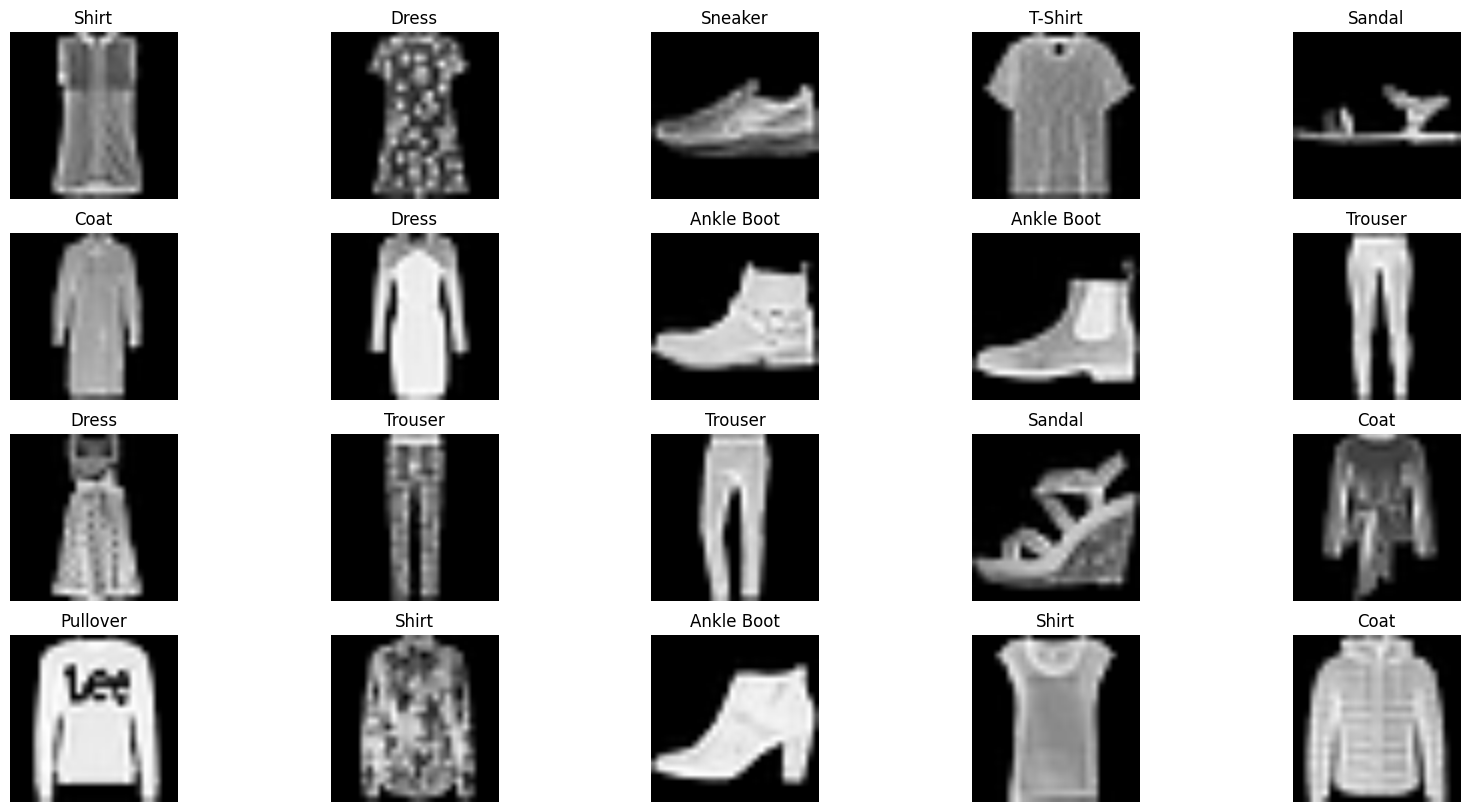

In [62]:
sample_dataset(submission_dataset)